In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from google.colab import files

import os
import unicodedata
import string
import random
import binascii

In [2]:
def upload_file():
  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

In [4]:
upload_file()
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [5]:
!kaggle datasets download -d sinclairg/surname-language-of-origin

  0% 0.00/2.79M [00:00<?, ?B/s]
100% 2.79M/2.79M [00:00<00:00, 198MB/s]


In [6]:
!ls

sample_data  surname-language-of-origin.zip


In [7]:
!unzip ./surname-language-of-origin.zip

Archive:  ./surname-language-of-origin.zip
  inflating: data/eng-fra.txt        
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


In [8]:
!ls && ls ./data/names

data  sample_data  surname-language-of-origin.zip
Arabic.txt   English.txt  Irish.txt	Polish.txt	Spanish.txt
Chinese.txt  French.txt   Italian.txt	Portuguese.txt	Vietnamese.txt
Czech.txt    German.txt   Japanese.txt	Russian.txt
Dutch.txt    Greek.txt	  Korean.txt	Scottish.txt


In [71]:
!head -n 10 ./data/names/Russian.txt

Ababko
Abaev
Abagyan
Abaidulin
Abaidullin
Abaimoff
Abaimov
Abakeliya
Abakovsky
Abakshin


In [10]:
DATA_PATH = './data/names'
for filename in os.listdir(DATA_PATH):
  with open(f'{DATA_PATH}/{filename}') as f:
    print('Filename', filename)
    print('Lines', len(f.readlines()))

Filename Irish.txt
Lines 232
Filename English.txt
Lines 3668
Filename Portuguese.txt
Lines 74
Filename Russian.txt
Lines 9408
Filename Vietnamese.txt
Lines 73
Filename German.txt
Lines 724
Filename Greek.txt
Lines 203
Filename Dutch.txt
Lines 297
Filename French.txt
Lines 277
Filename Chinese.txt
Lines 268
Filename Scottish.txt
Lines 100
Filename Japanese.txt
Lines 991
Filename Spanish.txt
Lines 298
Filename Italian.txt
Lines 709
Filename Polish.txt
Lines 139
Filename Arabic.txt
Lines 2000
Filename Korean.txt
Lines 94
Filename Czech.txt
Lines 519


In [11]:
os.listdir(DATA_PATH)

['Irish.txt',
 'English.txt',
 'Portuguese.txt',
 'Russian.txt',
 'Vietnamese.txt',
 'German.txt',
 'Greek.txt',
 'Dutch.txt',
 'French.txt',
 'Chinese.txt',
 'Scottish.txt',
 'Japanese.txt',
 'Spanish.txt',
 'Italian.txt',
 'Polish.txt',
 'Arabic.txt',
 'Korean.txt',
 'Czech.txt']

# Adding one more class (for Ukrainian language)
Note: data was taken from an open source through parsing: https://www.familytreedna.com/groups/ukrainian-dna/surnames

Here is the script used to transform data to the needed format:
```
import json

def process_names():
    ukrainian_suffixes = ['enko', 'chuk', 'chak', 'yshyn', 'ishyn', 'skyi', 'vych', 'ko']
    res = []
    with open('./surnames.json', 'r') as f:
        raw_surnames = json.loads(f.read())
        for p in raw_surnames['surnames']:
            if any(map(lambda s : p['name'].endswith(s), ukrainian_suffixes)):
                res.append(p['name'])
    print('Surnames: ', len(res))
    with open('./Ukrainian.txt', 'w') as f:
        f.write('\n'.join(res))


if __name__ == '__main__':
    process_names()
```

In [12]:
upload_file()
  
!mv ./Ukrainian.txt ./data/names/

Saving Ukrainian.txt to Ukrainian.txt
User uploaded file "Ukrainian.txt" with length 39041 bytes


In [13]:
!ls ./data/names

Arabic.txt   English.txt  Irish.txt	Polish.txt	Spanish.txt
Chinese.txt  French.txt   Italian.txt	Portuguese.txt	Ukrainian.txt
Czech.txt    German.txt   Japanese.txt	Russian.txt	Vietnamese.txt
Dutch.txt    Greek.txt	  Korean.txt	Scottish.txt


# Using TPUs for faster learning

In [14]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [15]:
strategy = tf.distribute.TPUStrategy(resolver)

# Preprocessing

### Turning unicode into ASCII
_Note: code is taken from an open source: [StackOverflow](https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-normalize-in-a-python-unicode-string/518232#518232)_

In [16]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s) # make sure it is matching the normal form
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


# Read a file and split into lines
def readLines(path):
    lines = open(path, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [17]:
category_lines = {}
all_categories = []

for filename in os.listdir(DATA_PATH):
    category = filename.split('.')[0]
    all_categories.append(category)
    lines = readLines(f'{DATA_PATH}/{filename}')
    category_lines[category] = lines

n_categories = len(all_categories)

In [18]:
all_categories, n_categories

(['Irish',
  'English',
  'Portuguese',
  'Russian',
  'Vietnamese',
  'German',
  'Greek',
  'Dutch',
  'French',
  'Chinese',
  'Scottish',
  'Japanese',
  'Spanish',
  'Italian',
  'Polish',
  'Arabic',
  'Ukrainian',
  'Korean',
  'Czech'],
 19)

In [19]:
pd.DataFrame({category: random.sample(category_lines[category], 10) for category in all_categories})

,Irish,English,Portuguese,Russian,Vietnamese,German,Greek,Dutch,French,Chinese,Scottish,Japanese,Spanish,Italian,Polish,Arabic,Ukrainian,Korean,Czech
0,O'Doherty,Finney,Ferro,Bekhtin,Thi,Kerner,Houlis,Aller,Boucher,Yue,Maclean,Shibata,Roma,Abategiovanni,Kaluza,Bishara,Rozhniatovskyi,Koo,Perevuznik
1,O'Dowd,Mackie,Ramires,Zhavoronsky,Thuy,Schmitt,Sotiris,Horn,Patenaude,Jia,Murphy,Sammiya,Moralez,Aiello,Serafin,Arian,Yanovych,Cha,Tikal
2,Donovan,Kristensen,Matos,Androsov,Ly,Simmon,Karnoupakis,Rooiakkers,Soucy,Lao,Crawford,Kawaii,Castro,Nanni,Rog,Touma,Levadnenko,Chi,Kirchma
3,Simon,Hurley,Cardozo,Liberman,Hoang,Kurzmann,Petrakis,Paulis,Allard,Chi,Milne,Hayata,Toset,Bover,Rudaski,Baba,Shulezhko,Jang,Jedlicka
4,Conall,Lester,Henriques,Pechinin,Vinh,Spitznogle,Chrysanthopoulos,Mas,Belrose,Hew,Fleming,Shimaoka,De la cruz,Notaro,Wawrzaszek,Wasem,Semchuk,Hwang,Macha
5,Pharlain,Vikers,Belo,Dovgello,Tong,Mayer,Galanopoulos,Haenraets,Robert,Miao,Hughes,Kurosawa,Iniguez,Martelli,Wojewodka,Asker,Stanislavchuk,Ma,Klimes
6,Domhnall,Large,Costa,Zheludev,Vu,Schermer,Tsogas,Haanrade,Gage,Sze,King,Satoya,Belmonte,Zini,Salomon,Maloof,Gosko,Jeong,Kuffel
7,O'Boyle,Elven,Basurto,Zhorov,Mach,Kopp,Fourakis,Klerkx,Coupe,Zhang,Cameron,Sugawara,Fernandez,Innocenti,Mencher,Gaber,Lepskyi,Ko,Jarzembowski
8,O'Toole,Naysmith,Santiago,Ametistov,Trang,Penzig,Paloumbas,Ogtrop,Armistead,Liang,Mcintyre,Hayashi,Salazar,Sordi,Bartosz,Bazzi,Zhodkevych,Suh,Hodoval
9,Bhrighde,Kennell,Cabral,Bachyanskas,Vuu,Schmid,Rigatos,Silje,Deniau,Luo,Whyte,Tsumura,Andreu,Acqua,Szwarc,Ba,Tysovskyi,Li,Wizner


## Target value distribution

In [20]:
sns.set_style('darkgrid')
sns.set(font_scale=1.4)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 <a list of 19 Text major ticklabel objects>)

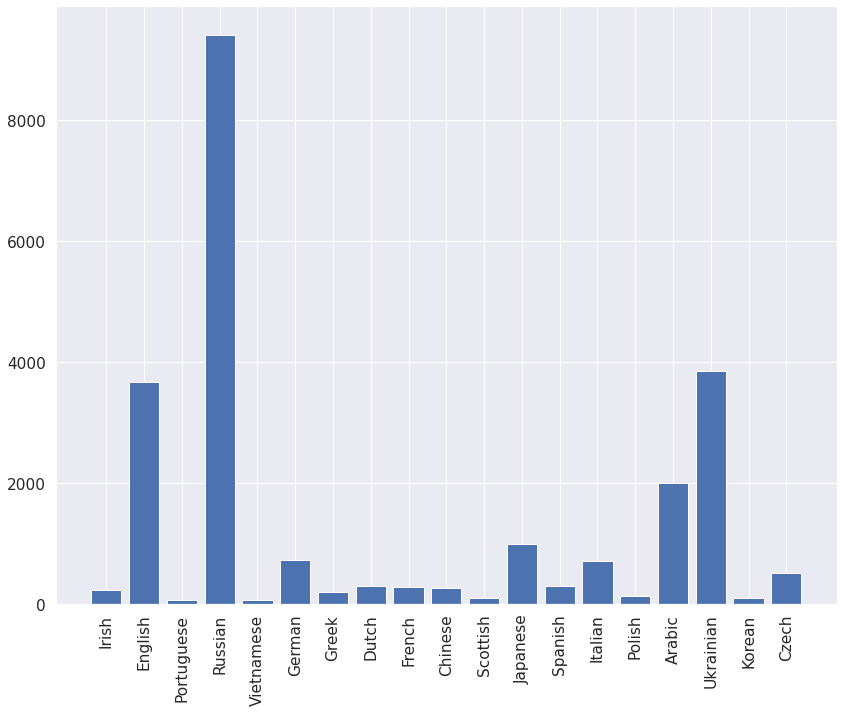

In [21]:
plt.figure(figsize=(14, 11))
plt.bar(category_lines.keys(), list(map(len, category_lines.values())))
plt.xticks(rotation=90)

In [22]:
print('Total entries:', sum(map(len, category_lines.values())))

Total entries: 23925


# Loading data to tf

## We will be using custom one-hot encoding. 
_Note: Out of the box encoding, and text vectorization for tensorflow deals with sentences, and shows pretty bad result when it comes to words, so we have to implement the encoding for the words with an assumption, that there is a specific limit on the length of the family name (we will be using 100, but that is debatable)_

In [23]:
def labeler(example, index):
    return example, tf.cast(index, tf.int64)

def letterToIndex(letter_code):
    return all_letters.find(chr(letter_code))

def one_hot_encode(lines, max_len):
    encoded_tensors = []
    for line in lines:
        idxs = np.array(list(map(letterToIndex, np.fromstring(line, dtype=np.uint8))))
        encoded = tf.one_hot(idxs, n_letters, dtype=tf.int32)
        encoded_tensors.append(tf.pad(
            encoded, [[0, max_len - encoded.shape[0]], [0, 0]], mode='CONSTANT', constant_values=0,
        ))
    return tf.stack(encoded_tensors)

def one_hot_decode(tensors):
    encoded_words = tensors.numpy()
    decoded_words = []
    for encoded_word in encoded_words:
        word = ''
        for encoded_letter in encoded_word:
            if encoded_letter[np.argmax(encoded_letter)] == 0:
                decoded_words.append(word)
                break
            word += all_letters[np.argmax(encoded_letter)]
    return decoded_words

In [24]:
print(one_hot_encode(['Adam', 'foo', 'bar', 'buzz'], 50))
print(one_hot_decode(one_hot_encode(['Adam', 'foo', 'bar', 'buzz'], 50)))

tf.Tensor(
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 1 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 1 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]], shape=(4, 50, 57), dtype=int32)
['Adam', 'foo', 'bar', 'buzz']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


# Training

In [25]:
labeled_datasets = []
MAX_WORD_LEN = 100

for i, category in enumerate(all_categories):
    print('Label:', i, 'Category:', category)
    lines_dataset = tf.data.Dataset.from_tensor_slices(one_hot_encode(category_lines[category], MAX_WORD_LEN))
    labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
    labeled_datasets.append(labeled_dataset)

Label: 0 Category: Irish


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


Label: 1 Category: English
Label: 2 Category: Portuguese
Label: 3 Category: Russian
Label: 4 Category: Vietnamese
Label: 5 Category: German
Label: 6 Category: Greek
Label: 7 Category: Dutch
Label: 8 Category: French
Label: 9 Category: Chinese
Label: 10 Category: Scottish
Label: 11 Category: Japanese
Label: 12 Category: Spanish
Label: 13 Category: Italian
Label: 14 Category: Polish
Label: 15 Category: Arabic
Label: 16 Category: Ukrainian
Label: 17 Category: Korean
Label: 18 Category: Czech


In [26]:
BUFFER_SIZE = 25000 # we can fit the whole dataset in buffer, it is pretty small
BATCH_SIZE = 64
VALIDATION_SIZE = 8000 # about 30% of the data

In [27]:
all_labeled_data = labeled_datasets[0]
for labeled_dataset in labeled_datasets[1:]:
    all_labeled_data = all_labeled_data.concatenate(labeled_dataset)

all_labeled_data = all_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)
all_labeled_data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 57), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [28]:
for encoded_name, label in all_labeled_data.take(10):
    print('Surname: ', one_hot_decode(tf.expand_dims(encoded_name, axis=0)))
    print('Language:', all_categories[label.numpy()], label.numpy())
    print('Correct label:', one_hot_decode(tf.expand_dims(encoded_name, axis=0))[0] in category_lines[all_categories[label.numpy()]])
    print('****')

Surname:  ['Finkelson']
Language: Russian 3
Correct label: True
****
Surname:  ['Jamsuev']
Language: Russian 3
Correct label: True
****
Surname:  ['Dykes']
Language: English 1
Correct label: True
****
Surname:  ['Toyoda']
Language: Japanese 11
Correct label: True
****
Surname:  ['Bratchichenko']
Language: Ukrainian 16
Correct label: True
****
Surname:  ['Padva']
Language: Russian 3
Correct label: True
****
Surname:  ['Juchenko']
Language: Russian 3
Correct label: True
****
Surname:  ['Hinchin']
Language: Russian 3
Correct label: True
****
Surname:  ['Danichenko']
Language: Russian 3
Correct label: True
****
Surname:  ['Nurhamitov']
Language: Russian 3
Correct label: True
****


## Getting train and validation data

In [29]:
train_data = all_labeled_data.skip(VALIDATION_SIZE).shuffle(BUFFER_SIZE)
validation_data = all_labeled_data.take(VALIDATION_SIZE)

In [30]:
train_dataset = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_data = validation_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [31]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy().shape)
  print()
  print('labels: ', label.numpy().shape)

texts:  (64, 100, 57)

labels:  (64,)


# Modelling

In [32]:
METRICS = [
      'accuracy',
    #   'mean_absolute_percentage_error', # was not too useful
    #   'mean_squared_logarithmic_error' # was not too useful
]

def make_model_rnn(metrics=METRICS):
    with strategy.scope():
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(MAX_WORD_LEN, n_letters)),
            # tf.keras.layers.Embedding(n_letters, 64),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(n_categories, activation='softmax')
        ])
        model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(1e-4),
                metrics=metrics)

    return model

In [33]:
model_rnn = make_model_rnn()
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 100, 128)         62464     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 19)                1235      
                                                                 
Total params: 109,075
Trainable params: 109,075
Non-trai

In [34]:
history = model_rnn.fit(train_dataset, epochs=50,
                    validation_data=validation_data,
                    validation_steps=30)

Epoch 1/50
249/249 [==============================] - 29s 68ms/step - loss: 2.4640 - accuracy: 0.3661 - val_loss: 2.0326 - val_accuracy: 0.3703
Epoch 2/50
249/249 [==============================] - 11s 42ms/step - loss: 1.9621 - accuracy: 0.4011 - val_loss: 1.6921 - val_accuracy: 0.4510
Epoch 3/50
249/249 [==============================] - 11s 42ms/step - loss: 1.7117 - accuracy: 0.4588 - val_loss: 1.5122 - val_accuracy: 0.5208
Epoch 4/50
249/249 [==============================] - 11s 43ms/step - loss: 1.5918 - accuracy: 0.5136 - val_loss: 1.4347 - val_accuracy: 0.5495
Epoch 5/50
249/249 [==============================] - 11s 43ms/step - loss: 1.5250 - accuracy: 0.5454 - val_loss: 1.4184 - val_accuracy: 0.5656
Epoch 6/50
249/249 [==============================] - 11s 43ms/step - loss: 1.4818 - accuracy: 0.5615 - val_loss: 1.3563 - val_accuracy: 0.5766
Epoch 7/50
249/249 [==============================] - 11s 42ms/step - loss: 1.4448 - accuracy: 0.5751 - val_loss: 1.3340 - val_accuracy:

# Examine the results:

In [35]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

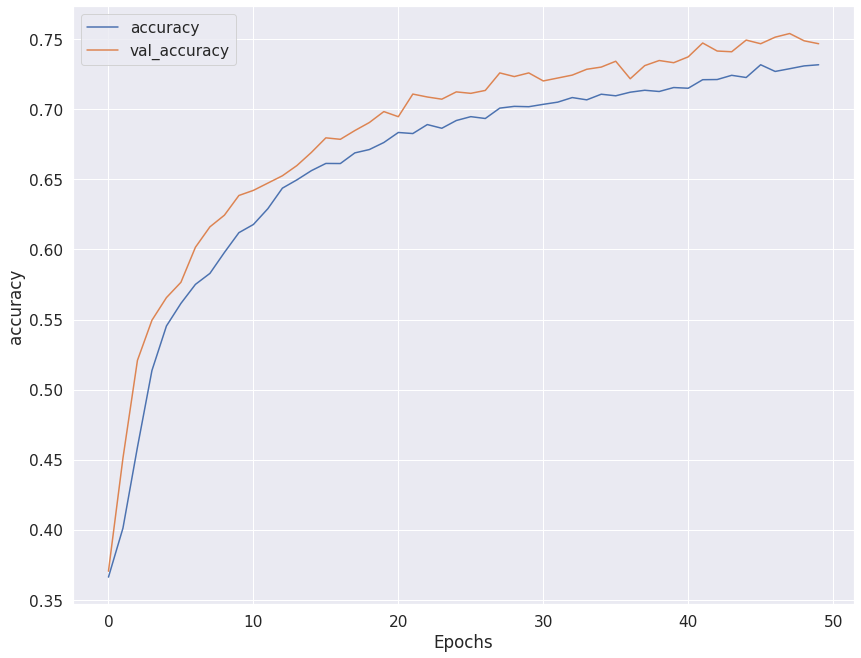

In [36]:
plt.figure(figsize=(14, 11))
plot_graphs(history, 'accuracy')

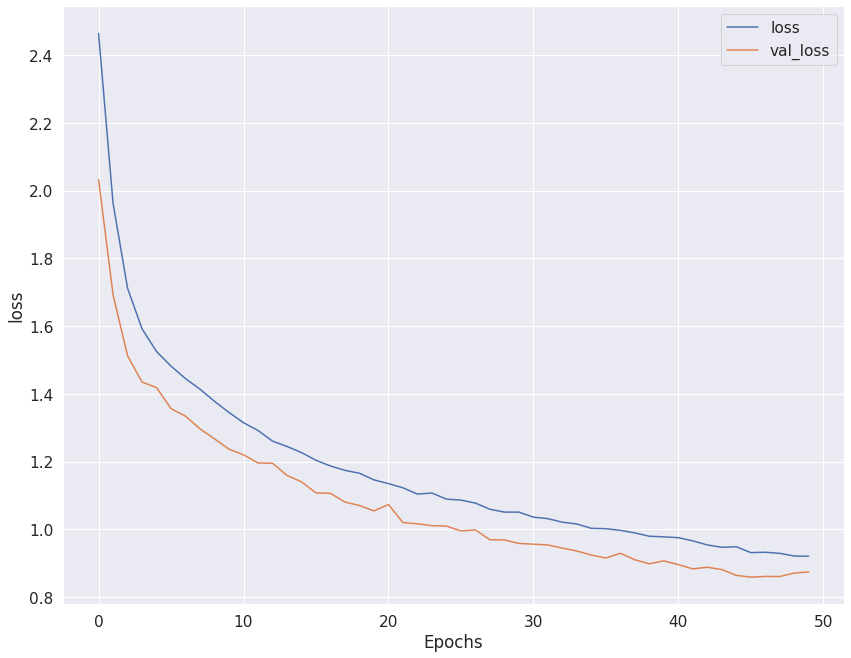

In [37]:
plt.figure(figsize=(14, 11))
plot_graphs(history, 'loss')

In [38]:
res = model_rnn.evaluate(validation_data)

print('Test Loss:', res[0])
print('Test Accuracy:', res[1])

125/125 [==============================] - 5s 23ms/step - loss: 0.8747 - accuracy: 0.7400
Test Loss: 0.874663770198822
Test Accuracy: 0.7400000095367432


In [40]:
def predict_name(model, name, k=3):
    predictions = model.predict(one_hot_encode([name], MAX_WORD_LEN))
    for i in np.argsort(predictions)[0][-k:]:
        print('>', all_categories[i])

In [42]:
predict_name(model_rnn, 'Tytarenko') # Ukrainian/Russian

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


> Czech
> Russian
> Ukrainian


In [44]:
predict_name(model_rnn, 'Pylypenko') # Russian/Ukrainian

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


> Czech
> Russian
> Ukrainian


In [46]:
predict_name(model_rnn, 'Huliev') # Asian

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


> Czech
> English
> Russian


In [48]:
predict_name(model_rnn, 'Kapusta') # Russian

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


> Czech
> Greek
> Russian


In [49]:
predict_name(model_rnn, 'Biden') # English

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


> German
> Russian
> English


In [51]:
predict_name(model_rnn, 'Trump') # English

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


> German
> Russian
> English


In [52]:
predict_name(model_rnn, 'Berest') # Russian

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


> Russian
> German
> English


In [53]:
predict_name(model_rnn, 'Castellanos') # Spanish

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


> Spanish
> Italian
> English


In [54]:
predict_name(model_rnn, 'Vale') # Spanish

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


> English
> Italian
> Russian


### Summary for RNN:
The model performed not so bad, taking into account that is the pretty basic model, and only 50 epochs, on the validation dataset at gave us **~74%**, which is not so bad for imbalanced data with 19 classes. 
Taking a look into charts of loss and accuracy we see some fluctuations at the last ~10 epochs, this looks like overfitting, so due to the lack of time I am unable to test many configurations and find a better one, but probably couple new dense layers, with several dropouts and maybe one more recursive layer would beat 85-90%. We can also try to vary parameters further, like smaller learning rate should make it less fluctant. (for some reason this model loves Czech so much, but otherwise the top 3 results usually contain the closest correct answer

### Result: **~74%**

# CNN model

In [55]:
def make_model_cnn(metrics=METRICS):
    with strategy.scope():
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(MAX_WORD_LEN, n_letters)),
            # tf.keras.layers.Embedding(n_letters, 64),
            tf.keras.layers.Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            tf.keras.layers.Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            tf.keras.layers.Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(n_categories, activation='softmax')
        ])
        model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(1e-4),
                metrics=metrics)

    return model

In [56]:
model_cnn = make_model_cnn()
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 128)          29312     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 64)            32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 25, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 25, 32)            8224      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 12, 32)          

In [57]:
history = model_cnn.fit(train_dataset, epochs=50,
                    validation_data=validation_data,
                    validation_steps=30)

Epoch 1/50
249/249 [==============================] - 12s 31ms/step - loss: 2.1530 - accuracy: 0.3673 - val_loss: 1.7723 - val_accuracy: 0.3818
Epoch 2/50
249/249 [==============================] - 6s 22ms/step - loss: 1.6905 - accuracy: 0.4608 - val_loss: 1.4948 - val_accuracy: 0.5198
Epoch 3/50
249/249 [==============================] - 6s 23ms/step - loss: 1.4419 - accuracy: 0.5626 - val_loss: 1.3212 - val_accuracy: 0.6021
Epoch 4/50
249/249 [==============================] - 6s 23ms/step - loss: 1.3158 - accuracy: 0.6138 - val_loss: 1.2195 - val_accuracy: 0.6531
Epoch 5/50
249/249 [==============================] - 7s 24ms/step - loss: 1.2133 - accuracy: 0.6558 - val_loss: 1.1136 - val_accuracy: 0.6823
Epoch 6/50
249/249 [==============================] - 6s 23ms/step - loss: 1.1251 - accuracy: 0.6862 - val_loss: 1.0359 - val_accuracy: 0.7026
Epoch 7/50
249/249 [==============================] - 6s 24ms/step - loss: 1.0582 - accuracy: 0.7050 - val_loss: 0.9734 - val_accuracy: 0.722

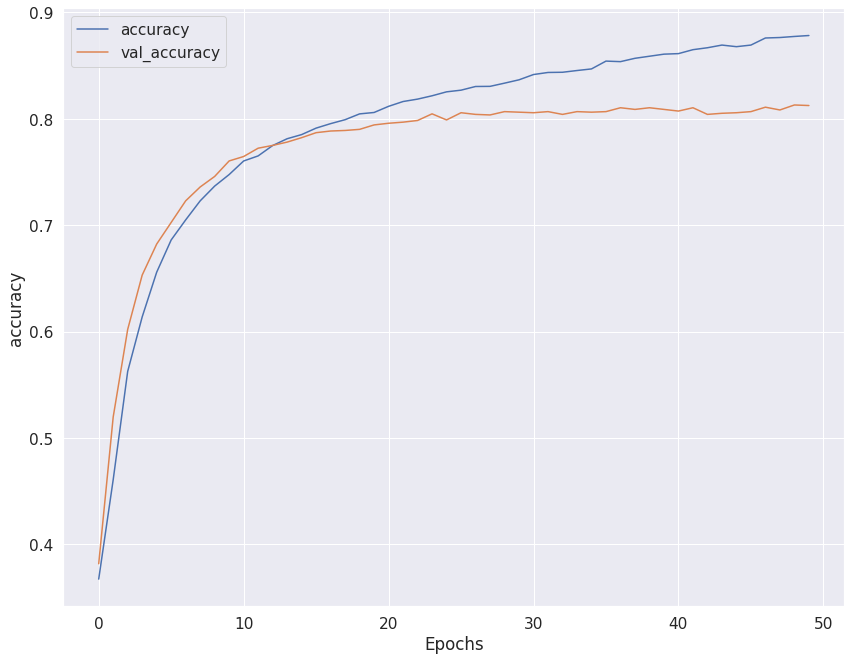

In [58]:
plt.figure(figsize=(14, 11))
plot_graphs(history, 'accuracy')

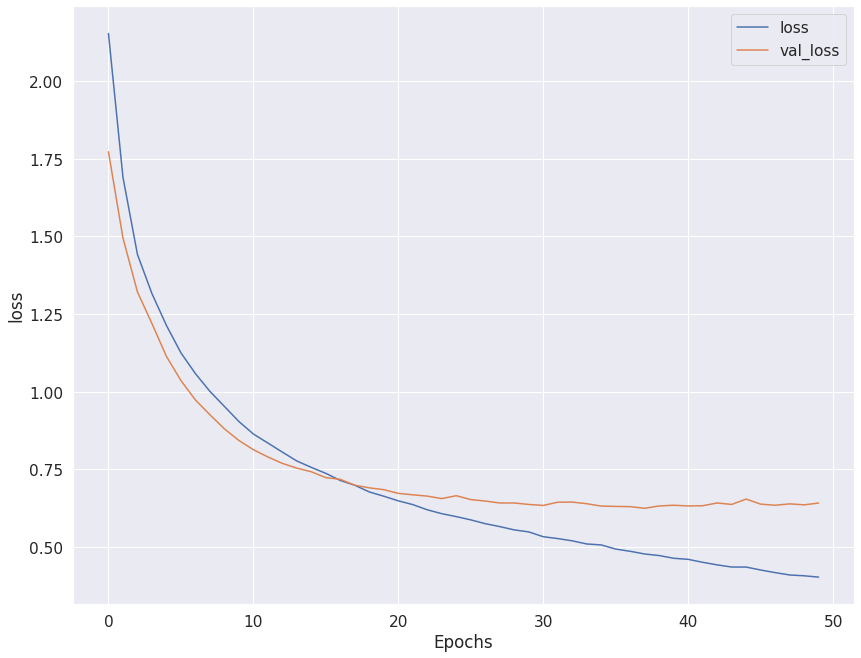

In [59]:
plt.figure(figsize=(14, 11))
plot_graphs(history, 'loss')

In [60]:
res = model_cnn.evaluate(validation_data)

print('Test Loss:', res[0])
print('Test Accuracy:', res[1])

125/125 [==============================] - 4s 18ms/step - loss: 0.6457 - accuracy: 0.8148
Test Loss: 0.6456531882286072
Test Accuracy: 0.8147500157356262


In [61]:
predict_name(model_cnn, 'Tytarenko') # Ukrainian/Russian

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


> Czech
> Russian
> Ukrainian


In [62]:
predict_name(model_cnn, 'Kapusta', 12) # Russian

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


> German
> Chinese
> Dutch
> Greek
> Portuguese
> Italian
> Spanish
> Russian
> Ukrainian
> Polish
> Japanese
> Czech


In [63]:
predict_name(model_cnn, 'Usyk') # Ukrainian

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


> Czech
> Japanese
> Russian


In [64]:
predict_name(model_cnn, 'Pylypenko') # Russian/Ukrainian

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


> Czech
> Russian
> Ukrainian


In [65]:
predict_name(model_cnn, 'Huliev') # Asian

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


> German
> Czech
> Russian


In [67]:
predict_name(model_cnn, 'Trump') # English

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


> French
> German
> English


In [68]:
predict_name(model_rnn, 'Biden') # English

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


> German
> Russian
> English


In [69]:
predict_name(model_rnn, 'Castellanos') # Spanish

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


> Spanish
> Italian
> English


In [70]:
predict_name(model_rnn, 'Vale') # English

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


> English
> Italian
> Russian


### Summary for CNN:
The model performed even better than the previous one, again, this is just a basic model, and only 50 epochs, on the validation dataset it gave us **~81,5%**, which is not so bad for imbalanced data with 19 classes. 
Taking a look into charts of loss and accuracy we see some fluctuations at the last ~10 epochs (exactly the same as for RNN), so that is probably overfitting. This model is deeper (and has more parameters than the first one), and this might be the cause for better performance, yet still more testing is required. We can also try to vary parameters further, like smaller learning rate should make it less fluctant. Overal beating 90% on this model is more than possible from the first glance, just more elaborate work on parameters and the architecture required, which is not done due to the lack of time.

### Result: **~81.5%**